<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/notebooks/ECCB_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text generation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Data processing

In [2]:
#source https://www.tensorflow.org/text/tutorials/text_generation
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
complete_text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(complete_text)} characters')

Length of text: 1115394 characters


In [4]:
complete_text[:250]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n'

In [5]:
vocab = sorted(set(complete_text))
print(f'{len(vocab)} unique characters')
print(vocab)

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
chars_to_ids = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)

def text_to_ids(text, vocab=vocab):
  chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
  return chars_to_ids(chars)

text = 'Hi mom!'
ids = text_to_ids(text)
print(ids)

tf.Tensor([21 48  2 52 54 52  3], shape=(7,), dtype=int64)


In [7]:
chars_from_ids = preprocessing.StringLookup(vocabulary=chars_to_ids.get_vocabulary(), invert=True, mask_token=None) #mask token = None - id_from_chars adds [UNK] token, not interested in that one

def ids_to_text(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy()

print(ids_to_text(ids))

b'Hi mom!'


## Creating the dataset for our model

In [8]:
all_ids = text_to_ids(complete_text)
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [9]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
seq_length=100
#We could have some sequences of length 50, some of 150 etc...!
sequences = ids_dataset.batch(seq_length, drop_remainder=True)

for s in sequences.take(1):
  print(ids_to_text(s))
for s in sequences.take(1):
  print(s)


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
tf.Tensor(
[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 15 44 45 54 57 44  2 62 44
  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47 44
 40 57  2 52 44  2 58 55 44 40 50  9  1  1 14 51 51 11  1 32 55 44 40 50
  7  2 58 55 44 40 50  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11
  1 38 54 60], shape=(100,), dtype=int64)


In [10]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

train_dataset = sequences.map(split_input_target)

for input_example, target_example in train_dataset.take(1):
    print("Input :", ids_to_text(input_example))
    print("Target:", ids_to_text(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


In [11]:
#Only training dataset
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size=64)

# Model architecture


In [19]:
#We are defining the model a bit differently this time. This is done to allow us to customize the text-generation process.
class MyBasicModel(tf.keras.Model):
  def __init__(self, vocab_size, rnn_units):
    super().__init__(self)

    self.onehot = tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x,'int64'), vocab_size))
    self.rnn = tf.keras.layers.SimpleRNN(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x= self.onehot(x)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = MyBasicModel(vocab_size=66, rnn_units=256)

#This is how we would define the model in a simple way
# model = tf.keras.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x,'int64'), 66)),
#     tf.keras.layers.SimpleRNN(256, return_sequences=True), #Return sequences allows us to compute loss from all the intermediate-states?
#     tf.keras.layers.Dense(66, activation='softmax'),
# ])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=20)

Epoch 1/20
175/175 [==============================] - 14s 71ms/step - loss: 2.8479 - accuracy: 0.2535
Epoch 2/20
175/175 [==============================] - 14s 77ms/step - loss: 2.2728 - accuracy: 0.3623
Epoch 3/20
175/175 [==============================] - 14s 73ms/step - loss: 2.1399 - accuracy: 0.3892
Epoch 4/20
175/175 [==============================] - 13s 70ms/step - loss: 2.0626 - accuracy: 0.4067
Epoch 5/20
175/175 [==============================] - 13s 71ms/step - loss: 2.0028 - accuracy: 0.4205
Epoch 6/20
175/175 [==============================] - 14s 75ms/step - loss: 1.9507 - accuracy: 0.4324
Epoch 7/20
175/175 [==============================] - 14s 75ms/step - loss: 1.9054 - accuracy: 0.4427
Epoch 8/20
175/175 [==============================] - 14s 74ms/step - loss: 1.8662 - accuracy: 0.4527
Epoch 9/20
175/175 [==============================] - 14s 73ms/step - loss: 1.8329 - accuracy: 0.4614
Epoch 10/20
175/175 [==============================] - 14s 77ms/step - loss: 1.802

# Text generation

In [14]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

def generate_shakespeare(model, length, start_string='ROMEO:'):
  ids_from_chars = preprocessing.StringLookup(
      vocabulary=list(vocab), mask_token=None)
  chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

  one_step_model = OneStep(model, chars_from_ids, chars_to_ids)

  states = None
  next_char = tf.constant([start_string])
  result = [next_char]

  for n in range(length):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


In [22]:
generate_shakespeare(model, 400, start_string='ROMEO:')

ROMEO:
I dlank. Pemplace it now him coppeich.
I have one string
Hat whug nied u'll prives in a villed from whith of houth ind,
I had the longs or allist Of of stallom thee.

BENVOLIO:
Well, well, in the fate tanged?

YORK:
Farthall my warding thrisoriod encoing it
But whenief that make herseling they
If ry lef Cloods, the Ohat would bevour you his hath gillvon arve I high.

BUCKINGHAM:
Then, all thit st 

________________________________________________________________________________


# LSTM + Embedding


Embedding layer can improve our model further

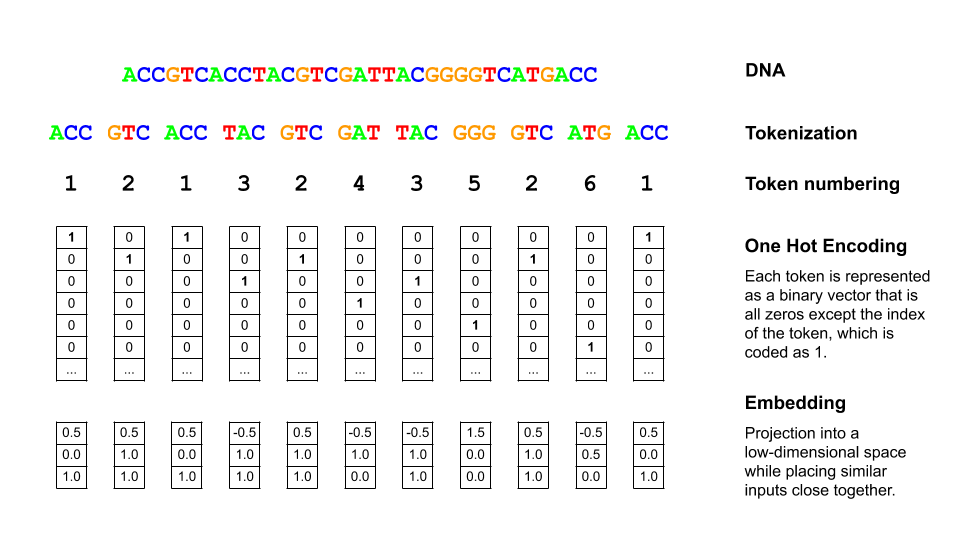

The Embedding layer does have limitations:

The input needs to be integers in [0, vocab_length).
No bias.
No activation.

In [23]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

# Simple definition
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(66, 256),
#     tf.keras.layers.LSTM(256, return_sequences=True), #Return sequences allows us to compute loss from all the intermediate-states
#     tf.keras.layers.Dense(66, activation='softmax'),
# ])

model = MyModel(
    vocab_size=len(chars_to_ids.get_vocabulary()),
    embedding_dim=256,
    rnn_units=1024)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=20)

Epoch 1/20
175/175 [==============================] - 12s 52ms/step - loss: 2.7354 - accuracy: 0.2799
Epoch 2/20
175/175 [==============================] - 10s 53ms/step - loss: 1.9926 - accuracy: 0.4176
Epoch 3/20
175/175 [==============================] - 10s 53ms/step - loss: 1.7133 - accuracy: 0.4922
Epoch 4/20
175/175 [==============================] - 10s 53ms/step - loss: 1.5509 - accuracy: 0.5351
Epoch 5/20
175/175 [==============================] - 10s 53ms/step - loss: 1.4525 - accuracy: 0.5596
Epoch 6/20
175/175 [==============================] - 10s 54ms/step - loss: 1.3836 - accuracy: 0.5767
Epoch 7/20
175/175 [==============================] - 10s 54ms/step - loss: 1.3313 - accuracy: 0.5903
Epoch 8/20
175/175 [==============================] - 10s 55ms/step - loss: 1.2864 - accuracy: 0.6011
Epoch 9/20
175/175 [==============================] - 10s 54ms/step - loss: 1.2448 - accuracy: 0.6122
Epoch 10/20
175/175 [==============================] - 11s 55ms/step - loss: 1.205

In [24]:
generate_shakespeare(model, 400, start_string="ROMEO:")

ROMEO:
Father, be he night.

MERCUTIO:
Why, it were well fellows that I have, both: if
it better, I'll see your woes of warwick; Elpow he mad
And you becim before your grace:
'You did but the stuff being one when you can brook it,
He hath he in eleven hand of heaven;
On she knew her, when menavelloo was but yet
Ere yet the cause will or our meaning.

LUCENTIO:
And then, for I must pait your husband's Ka 

________________________________________________________________________________
